# Pré-Processamento

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import re
import nltk
import ast
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv("data/full_articles_dataset.csv",converters={'biased_words4':ast.literal_eval})

In [ ]:
df.columns

Index(['sentence', 'news_link', 'outlet', 'topic', 'type', 'group_id',
       'num_sent', 'Label_bias', 'Label_opinion', 'article', 'biased_words4'],
      dtype='object')

## 1 - Features Importantes
- Label_bias (categórica): Indica se o texto foi classificado como enviesado, não-enviesado ou se não foi possível atingir um consenso quanto a classificação.
- Biased_words(vetor): Indica as palavras marcadas como "denunciantes" da presença de viés.
- Topic(categórica): Indica o assunto do texto, dentro das categorias
- Type: Denota o posicionamento do viés, separados como esquerda, centro ou direita.
- Outlet: Portal de origem da notícia

In [ ]:
df['Label_bias'].unique()

array(['Biased', 'Non-biased', 'No agreement'], dtype=object)

In [ ]:
df['topic'].unique()

array(['elections-2020', 'sport', 'immigration', 'environment',
       'abortion', 'student-debt', 'vaccines', 'white-nationalism',
       'coronavirus', 'trump-presidency', 'middle-class', 'gender',
       'international-politics-and-world-news', 'gun-control'],
      dtype=object)

In [ ]:
df['type'].unique()

array(['center', 'left', 'right'], dtype=object)

## 2 - Pré-Processamento

*Observação*: as funções relativas a entradas textuais são testadas individualmente com a coluna 'sentence'. Essa feature traz a frase na qual os participantes da pesquisa viram um viés.

Quando formos realizar os treinos e a validação, utilizaremos todo o texto que compõe o documento analisado. Se mostrar-se interessante, podemos averiguar a performance reduzindo o corpus a, justamente, essas sentenças.

### 2.1 - Básico textual (remoção de stopwords, filtro de expressões com números, etc)

- A priori, vamos considerar como tokens todas as palavras que:
    - tenham mais do que 3 letras;
    - não possuam números;
    - não sejam siglas (como U.S.) nem que tenham um símbolo diferente de letra pós ou precedido por uma (como é o caso de separação entre palavras ao pular linha, e.g. "fari-");
    - não estejam nas stopwords do inglês.

- Uma decisão importante, especialmente no contexto de viés, é exclusão das das aspas. Isso pode ocorrer tanto de forma a ironizar acontecimentos como a corroborar algum conhecimento com argumento de autoridade enviesado, mas é algo que acreditamos estar diretamente relacionado ao conteúdo da frase, independetemente da grafia ao redor. Afinal, queremos tentar identificar a intenção. Seria interessante, para um próximo trabalho, tentar considerar as aspas e o que estivesse sob seus limites como algum tipo de incentivo ou demérito.

- Mediante a escolha do usuário, aplicaremos um stemmer(Porter/Lancaster) ou um lemmatizer. Também podemos simplesmente não aplicar nenhum.

In [ ]:
digit_pattern = r'\d+(\.\d+)?'
solo_quotations_pattern = pattern = r"^(?:' '|\\" "|\`\`)$"

remove_quotation = r"'\b|\b'\s|\s'\b|\"\b|\b\"\s|\s\"\b|``\b|\b``\s|\s``\b" # como em "America is Great"
remove_symbols_only = r'\b[^\w\s]+\b' # como em '--'
remove_symbols_if_aside = r'\b[^\w\s]|[^\w\s]\b' # como em 'dog-'

remove_patterns = remove_quotation,remove_symbols_if_aside, remove_symbols_only

stop_words = set(stopwords.words('english')) # talvez o set deixe mais rápido

def preprocess_basic_text(data,columns):

    for col in columns:

       prepped_texts = []

       for doc in data[col]:

            if type(doc) == list:
              doc = ','.join(doc)
            # Remove acentos e põe tudo para lower case
            doc = unidecode(doc).lower()
            tokens = word_tokenize(doc,language="english")

            tokens = [
                re.sub('|'.join(remove_patterns),'',t)
                for t in tokens
                if not bool(re.search(digit_pattern,t))
                and t not in string.punctuation
                and t not in stop_words
            ]

            tokens = [
                t for t in tokens
                if not bool(re.match(solo_quotations_pattern,t))
                and len(t) >= 3
             ]

            prepped_texts.append(tokens)

       data[col] = prepped_texts

    return data

df_copy = df.copy()
df_copy = preprocess_basic_text(df_copy,['sentence'])
df_copy['sentence'].head()

0    [youtube, making, clear, birtherism, platform,...
1    [increasingly, bitter, dispute, american, wome...
2    [may, humanitarian, crisis, driving, vulnerabl...
3    [professor, teaches, climate, change, classes,...
4    [looking, around, united, states, never, enoug...
Name: sentence, dtype: object

### 2.2 - Stemmers

- Temos o objetivo de avaliar como diferentes estratégias de stemming afetam os resultados do treinamento. A função a seguir visa abstrair esse passo para um etapa separada de pré-processamento.
- Serão testados os stemmer de Porter e de Lancaster, além da lematização via WordNet. Vamos também obter os resultados do modelo quando utilizados sem qualquer stemmer.

In [ ]:
def apply_stemmer_individual(sentence, stemmer_type:str):

    # Função a ser executada para cada sentença, com expectativa de uso em algum filtro, por exemplo

    stemmer = {}
    lemmatizer = {}

    if stemmer_type == "Porter":
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in sentence]

    elif stemmer_type == "Lancaster":
        stemmer = LancasterStemmer()
        return [stemmer.stem(token) for token in sentence]

    else:  # "Wordnet":
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.stem(token) for token in sentence]

In [ ]:
df_copy['sentence'] = df_copy['sentence'].apply(lambda x: apply_stemmer_individual(x,"Porter"))
df_copy['sentence'].head()

0    [youtub, make, clear, birther, platform, year,...
1    [increasingli, bitter, disput, american, women...
2    [may, humanitarian, crisi, drive, vulner, peop...
3    [professor, teach, climat, chang, class, subje...
4    [look, around, unit, state, never, enough, wel...
Name: sentence, dtype: object

In [ ]:
# generalizando a aplicação pra todas as instâncias
def apply_stemmer_for_all(data,columns,stemmer_flag=False,stemmer_type=None):

  if stemmer_flag == False:
    return data

  for col in columns:
    data[col] = data[col].apply(lambda x: apply_stemmer_individual(x,stemmer_type))
  return data

### 2.3 - Encoding (palavras)

- Para representar as palavras, vamos criar um encoding com base na frequência apresentada no corpus.
- Utilizaremos alguns números para representar determinadas semânticas:
  - padding("pad"), necessário para deixar todas as entradas com mesmo tamanho, terá o valor 0.
  - start-of-sequence("sos"), usado para identificar o ínicio de cada sentença, terá o número 1
  - unknown, para marcar palavras desconhecidas, terá o número 2

In [ ]:
SOS = "<sos>"
PADDING = "<pad>"
UNKNOWN = "<ukn>"

In [ ]:
def add_padding_and_sos(data, columns):


    for col in columns:
        max_length = max(len(seq) for seq in data[col])
        for index,row in data.iterrows():
            document = [SOS] + row[col]
            paddings = (max_length - len(row[col])) * [PADDING]
            document += paddings
            data.at[index,col] = document

    return data

In [ ]:
df_copy = add_padding_and_sos(df_copy, ['sentence'])

In [ ]:
print(df_copy.loc[190,'sentence'])

['<sos>', 'rather', 'reduc', 'feder', 'subsidi', 'univers', 'place', 'leftist', 'institut', 'merci', 'free', 'market', 'obama', 'want', 'increas', 'amount', 'student', 'borrow', 'interest', 'govern', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


- Construindo o vocabulário com base na frequência de aparecimento.
  - *Obs*: note a colocação de determinadas tags logo no ínicio

In [ ]:
def create_vocabulary(data, columns):
  """ Retorna uma lookup table (StaticVocabularyTable) """

  vocab = Counter()
  for col in columns:
      for document in data[col]:
          vocab.update(document)

  words = tf.constant([PADDING] +
                      [SOS] +
                      [UNKNOWN] +
                      [word for word in vocab.keys() if word != PADDING and word != SOS]
  )
  words_ids = tf.range(len(vocab)+1, dtype=tf.int64) # +1 porque unknown é o único não mapeado
  vocab_init = tf.lookup.KeyValueTensorInitializer(words,words_ids)
  num_oov_buckets = 10000 # bucket para palavras desconhecidas
  vocab_table = tf.lookup.StaticVocabularyTable(vocab_init,num_oov_buckets)

  return vocab_table

- Demonstração de como estão os encodings de algumas palavras.

In [ ]:
vocab_table = create_vocabulary(df_copy, columns=['sentence'])
vocab_table.lookup(tf.constant([b'nice trump move'.split(b' ')]))

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2628,  113,  635]])>

- Convertendo os tokens para o índice na tabela.

In [ ]:
def convert_words_to_freq(data, vocab, columns):

  for index, row in data.iterrows():

    for col in columns:
      doc = tf.constant(row[col])
      doc_ided = vocab.lookup(doc).numpy() if len (doc) > 0 else []
      data.at[index, col] = doc_ided

  return data

In [ ]:
df_copy = convert_words_to_freq(df_copy, vocab_table, ['sentence'])
df_copy.head(2)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1.0,1.0,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"[belated, birtherism]"
1,"[1, 18, 19, 20, 21, 22, 23, 24, 25, 24, 26, 27...",https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1.0,1.0,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",[bitter]


### 2.4 - One-hot encoding para features categóricas

In [ ]:
def cats_to_one_hot(data,column_names):

  df_encoded = pd.get_dummies(data[column_names]).astype(np.float32)
  data = pd.concat([data,df_encoded],axis=1)

  return data

In [ ]:
df_copy.loc[1,'sentence']

array([ 1, 18, 19, 20, 21, 22, 23, 24, 25, 24, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [ ]:
df_copy = cats_to_one_hot(df_copy, column_names=['topic','outlet','type','Label_opinion'])
df_copy.head(3)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,...,outlet_msnbc,outlet_reuters,outlet_usa-today,type_center,type_left,type_right,Label_opinion_Entirely factual,Label_opinion_Expresses writer’s opinion,Label_opinion_No agreement,Label_opinion_Somewhat factual but also opinionated
0,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1.0,1.0,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"[1, 18, 19, 20, 21, 22, 23, 24, 25, 24, 26, 27...",https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1.0,1.0,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,"[1, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51...",https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1.0,1.0,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 2.5 - Limpando features

In [ ]:
def drop_columns(data, column_names):
  return data.drop(column_names,axis=1)

In [ ]:
df_copy = drop_columns(df_copy,column_names=['news_link','group_id'])
df_copy.head(1)
df_copy.shape

(1690, 38)

### 2.7 - Compilando pipeline de pré-processamento

In [ ]:
class VocabularyConversionTransformer(BaseEstimator,TransformerMixin):
  def __init__(self,vocab_columns, columns_to_be_converted):
    self.vocab_table = None
    self.columns_to_be_converted = columns_to_be_converted
    self.vocab_columns = vocab_columns

  def fit(self, X, y=None):
    self.vocab_table = create_vocabulary(X,self.vocab_columns)
    return self

  def transform(self,X,y=None):
    return convert_words_to_freq(X,columns=self.columns_to_be_converted,vocab=self.vocab_table)

  def get_vocabulary(self):
    return self.vocab_table


In [ ]:
def preprocess(data,stemmer_flag=False,stemmer_type=None):

  one_hot_columns = ['topic','outlet','type','Label_bias']
  columns_to_drop = ['news_link','group_id', 'Label_opinion','num_sent'] + one_hot_columns
  vocab_columns = ['biased_words4']
  text_columns = ['article', 'sentence', 'biased_words4']

  preprocess_pipeline = [
      ('Tokenização', FunctionTransformer(preprocess_basic_text,kw_args={'columns': text_columns})),
      ('Stemming', FunctionTransformer(apply_stemmer_for_all, kw_args={'columns':text_columns,
                                                                      'stemmer_flag': stemmer_flag,
                                                                      'stemmer_type': stemmer_type
                                                                      })),
      ('SOS/Padding Addition', FunctionTransformer(add_padding_and_sos, kw_args={'columns':text_columns})),
      ('Vocab Creation and Word-Int Conversion', VocabularyConversionTransformer(vocab_columns=vocab_columns,columns_to_be_converted=text_columns)),
      ('One-hot-encoding', FunctionTransformer(cats_to_one_hot,kw_args={'column_names':one_hot_columns})),
      ('Dropping features', FunctionTransformer(drop_columns,kw_args={'column_names':columns_to_drop})),
  ]

  pipeline = Pipeline(preprocess_pipeline)

  data = pipeline.fit_transform(data)

  vocab = pipeline.named_steps['Vocab Creation and Word-Int Conversion'].get_vocabulary()

  return data, vocab

In [ ]:
data, vocab = preprocess(df.copy(),True,stemmer_type="Porter")

In [ ]:
type(data['sentence'].iloc[0])

numpy.ndarray

### 2.7 - Salvando dataset final (e vocabulário)


In [ ]:
""" def list_to_str(x):
    str = np.array2string(x, separator=',').replace('\n', '')
    return str """

" def list_to_str(x):\n    str = np.array2string(x, separator=',').replace('\n', '')\n    return str "

In [ ]:
""" # A lista presente na coluna "article" é muito grande, então para convertê-la corretamente
# precisamos modificar uma configuração do Numpy
import sys
np.set_printoptions(threshold=sys.maxsize)

data.article.apply(list_to_str)
data.sentence.apply(list_to_str)
data.biased_words4.apply(list_to_str) """

' # A lista presente na coluna "article" é muito grande, então para convertê-la corretamente\n# precisamos modificar uma configuração do Numpy\nimport sys\nnp.set_printoptions(threshold=sys.maxsize)\n\ndata.article.apply(list_to_str)\ndata.sentence.apply(list_to_str)\ndata.biased_words4.apply(list_to_str) '

In [ ]:
data.to_csv('data/final_dataset.csv', index=False)

In [ ]:
keys = tf.constant(list(range(vocab.size())))
keys = tf.strings.as_string(keys).numpy().tolist()
values = [vocab.lookup(tf.constant(key)).numpy() for key in keys]

vocab_dict = {key: value for key, value in zip(keys, values)}

with open('data/vocabulary_table.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)

# Redes Neurais

Esse notebook tratará da implementação, do treino e da avaliação inicial de redes neurais recorrentes (especificamente de células LSTM) na busca pela solução do seguinte problema de classificação: identificação de de viés político em textos. O tamanho desses textos é algo a ser arbitrado e até mesmo utilizado como comparação: podemos utilizar somente as sentenças que foram marcadas por conter viés, ou mesmo o texto na íntegra da notícia.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

- Carregamento do dataset e do vocabulário, totalmente perfilados pelo notebook de pré-processamento.

## 1 - Separando o dataset

In [ ]:
label_columns = ['Label_bias_Biased','Label_bias_No agreement', 'Label_bias_Non-biased']
labels = data[label_columns]
features = data.drop(label_columns, axis=1)

In [ ]:
def train_valid_test_split(features, labels):
    """ Retorna uma lista de tuplas contendo os datasets de features e de labels para cada segmento (treino, validação, teste) """

    # Treino-val e Teste
    X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2,stratify=labels, random_state=104)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

In [ ]:
train, validation, test = train_valid_test_split(features,labels)

train_df, train_labels = train
validation_df, validation_labels = validation
test_df, test_labels = test

print(f"Treino:{train_df.shape} ----- Validação: {validation_df.shape} ------ Teste: {test_df.shape}")

Treino:(1081, 28) ----- Validação: (271, 28) ------ Teste: (338, 28)


## 2 - Estruturando arquitetura da rede neural

- Vamos criar uma camada de embeddings. No caso atual, só conseguimos utilizar uma feature do tipo texto por vez, tendo em vista que o embedding é treinado junto da rede como um todo. Uma das ideias futuras seria utilizar um modelo pré-treinado com o vocabulário reduzido ao nosso, mas para alguns testes, essa arquitetura será interessante.

### 2.1 - Parte Textual (artigo)

In [ ]:
embed_size = 64

text_input_length = len(train_df.loc[1,'article'])
text_input = keras.layers.Input(shape=(text_input_length,))
embedding_layer = keras.layers.Embedding(input_dim=int(vocab_table.size())+5000,
                                         output_dim=embed_size,
                                         mask_zero=True)(text_input)

#embedding_output = keras.layers.Bidirectional(keras.layers.LSTM(embed_size))(embedding_layer)
embedding_output = keras.layers.LSTM(embed_size)(embedding_layer)


### 2.2 - Parte de Metadados

In [ ]:
feature_input_length = len(train_df.columns) - 3
feature_input = keras.layers.Input(shape=(feature_input_length,))

In [ ]:

from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score


from sklearn.metrics import precision_score, recall_score




### 2.3 - Modelo final

In [ ]:
concatenated = keras.layers.concatenate([embedding_output,feature_input], axis=-1)
reshaped = keras.layers.Reshape((-1, concatenated.shape[-1]))(concatenated)  # Add time dimension
gru_layer1 = keras.layers.LSTM(128)(reshaped)
dense = keras.layers.Dense(32, activation = 'relu')(gru_layer1)
dropout = keras.layers.Dropout(0.6)(dense) ### adicionando uma camada de regularização para diminuir diferença entre treino e validaçao
output = keras.layers.Dense(3, activation="softmax")(dropout)

model = tf.keras.Model(inputs=[text_input,feature_input], outputs=output)
#model.compile(loss="categorical_crossentropy",optimizer="adam")
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(class_id=0, name = 'prec_class0'),
                       Precision(class_id=1, name = 'prec_class1'),
                       Precision(class_id=2, name = 'prec_class2'),
                       Recall(class_id=0, name = 'rec_class0'),
                       Recall(class_id=1, name = 'rec_class1'),
                       Recall(class_id=2, name = 'rec_class2')])

## Modelo Sequencial:

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 3000)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 3000, 64)     1359296     ['input_17[0][0]']               
                                                                                                  
 lstm_15 (LSTM)                 (None, 64)           33024       ['embedding_8[0][0]']            
                                                                                                  
 input_18 (InputLayer)          [(None, 25)]         0           []                               
                                                                                            

## 3 - Treinando a rede

### 3.1 - Função auxiliar para fragmentar os inputs por tipo de feature

In [ ]:
def split_metadata_and_text_features(data,text_column):

    """
        Realiza a separação entre as features de texto e de metadados.
        O parâmetro "text_column" diz qual será a coluna textual que utilizaremos, dado que
        atualmente, precisamos escolher somente uma.
    """

    data = data.copy()

    text_features = tf.constant(data[text_column].values.tolist())
    metadata_features = data.drop(['article','sentence','biased_words4'],axis=1)

    return [text_features, metadata_features]

### 3.2 - Callback para salvar modelo a cada epoch

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="models/article_model.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

### 3.3 - Treinamento efetivo

In [ ]:
model_train_metrics = model.fit(split_metadata_and_text_features(train_df,'article'),
          train_labels,
          epochs=25,
          validation_data=(split_metadata_and_text_features(validation_df,'article'), validation_labels),
          batch_size=64,
          callbacks=[checkpoint_cb]
)

Epoch 1/25
17/17 [==============================] - 50s 3s/step - loss: 1.0386 - accuracy: 0.5439 - prec_class0: 0.7600 - prec_class1: 0.0000e+00 - prec_class2: 0.0000e+00 - rec_class0: 0.0292 - rec_class1: 0.0000e+00 - rec_class2: 0.0000e+00 - val_loss: 0.9176 - val_accuracy: 0.6015 - val_prec_class0: 0.6645 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.0000e+00 - val_rec_class0: 0.6196 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0000e+00
Epoch 2/25
17/17 [==============================] - 42s 3s/step - loss: 0.9015 - accuracy: 0.5967 - prec_class0: 0.6429 - prec_class1: 0.0000e+00 - prec_class2: 0.6522 - rec_class0: 0.6508 - rec_class1: 0.0000e+00 - rec_class2: 0.0893 - val_loss: 0.8946 - val_accuracy: 0.6384 - val_prec_class0: 0.6989 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.2500 - val_rec_class0: 0.3988 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0119
Epoch 3/25
17/17 [==============================] - 43s 3s/step - loss: 0.8686 - accuracy: 0.6429 - prec_cla

0 --> enviesado
1 --> sem acordo
2 --> sem vies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extrair as métricas do treinamento
accuracy = model_train_metrics.history['accuracy']
val_accuracy = model_train_metrics.history['val_accuracy']
prec_class0 = np.array(model_train_metrics.history['prec_class0'])
prec_class1 = np.array(model_train_metrics.history['prec_class1'])
prec_class2 = np.array(model_train_metrics.history['prec_class2'])
rec_class0 = np.array(model_train_metrics.history['rec_class0'])
rec_class1 = np.array(model_train_metrics.history['rec_class1'])
rec_class2 = np.array(model_train_metrics.history['rec_class2'])
val_prec_class0 = np.array(model_train_metrics.history['val_prec_class0'])
val_prec_class1 = np.array(model_train_metrics.history['val_prec_class1'])
val_prec_class2 = np.array(model_train_metrics.history['val_prec_class2'])
val_rec_class0 = np.array(model_train_metrics.history['val_rec_class0'])
val_rec_class1 = np.array(model_train_metrics.history['val_rec_class1'])
val_rec_class2 = np.array(model_train_metrics.history['val_rec_class2'])

# Calcular o F1-score para cada classe
f1_class0 = 2 * (prec_class0 * rec_class0) / (prec_class0 + rec_class0 + 1e-15)
f1_class1 = 2 * (prec_class1 * rec_class1) / (prec_class1 + rec_class1 + 1e-15)
f1_class2 = 2 * (prec_class2 * rec_class2) / (prec_class2 + rec_class2 + 1e-15)
val_f1_class0 = 2 * (val_prec_class0 * val_rec_class0) / (val_prec_class0 + val_rec_class0 + 1e-15)
val_f1_class1 = 2 * (val_prec_class1 * val_rec_class1) / (val_prec_class1 + val_rec_class1 + 1e-15)
val_f1_class2 = 2 * (val_prec_class2 * val_rec_class2) / (val_prec_class2 + val_rec_class2 + 1e-15)

# Criar subplots para os gráficos
fig, axs = plt.subplots(3, sharex=True, figsize=(8, 12))

# Gráfico de accuracy
axs[0].plot(accuracy, label='Train Accuracy', linewidth=2)
axs[0].plot(val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='--')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Gráfico de precision para cada classe
axs[1].plot(prec_class0, label='Train Precision - Class 0', linewidth=2)
axs[1].plot(prec_class1, label='Train Precision - Class 1', linewidth=2)
axs[1].plot(prec_class2, label='Train Precision - Class 2', linewidth=2)
axs[1].plot(val_prec_class0, label='Validation Precision - Class 0', linewidth=2, linestyle='--')
axs[1].plot(val_prec_class1, label='Validation Precision - Class 1', linewidth=2, linestyle='--')
axs[1].plot(val_prec_class2, label='Validation Precision - Class 2', linewidth=2, linestyle='--')
axs[1].set_ylabel('Precision')
axs[1].legend()

# Gráfico de recall para cada classe
axs[2].plot(rec_class0, label='Train Recall - Class 0', linewidth=2)
axs[2].plot(rec_class1, label='Train Recall - Class 1', linewidth=2)
axs[2].plot(rec_class2, label='Train Recall - Class 2', linewidth=2)
axs[2].plot(val_rec_class0, label='Validation Recall - Class 0', linewidth=2, linestyle='--')
axs[2].plot(val_rec_class1, label='Validation Recall - Class 1', linewidth=2, linestyle='--')
axs[2].plot(val_rec_class2, label='Validation Recall - Class 2', linewidth=2, linestyle='--')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Recall')
axs[2].legend()

# Ajustar o layout
plt.tight_layout()

# Exibir os gráficos
plt.show()

# Imprimir os valores de F1-score para cada classe
print('F1-score - Class 0:', f1_class0[-1])
print('F1-score - Class 1:', f1_class1[-1])
print('F1-score - Class 2:', f1_class2[-1])
print('Validation F1-score - Class 0:', val_f1_class0[-1])
print('Validation F1-score - Class 1:', val_f1_class1[-1])
print('Validation F1-score - Class 2:', val_f1_class2[-1])



### 3.4 Teste do Modelo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular as métricas no conjunto de teste
test_loss, test_accuracy, test_precision_class0, test_precision_class1, test_precision_class2, test_recall_class0, test_recall_class1, test_recall_class2 = model.evaluate(split_metadata_and_text_features(test_df, 'article'), test_labels)


11/11 [==============================] - 5s 493ms/step - loss: 2.1125 - accuracy: 0.5621 - prec_class0: 0.6888 - prec_class1: 0.1053 - prec_class2: 0.4312 - rec_class0: 0.6650 - rec_class1: 0.0667 - rec_class2: 0.4476


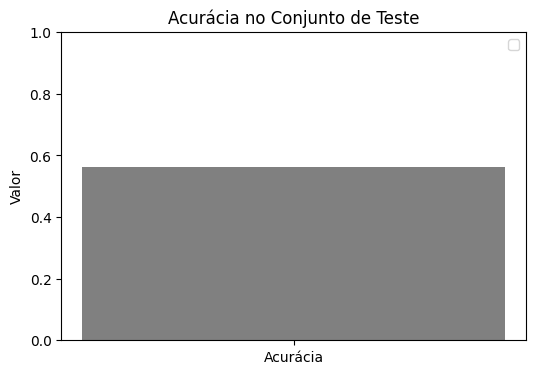

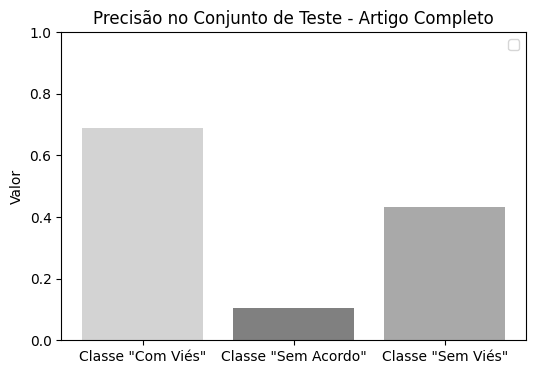

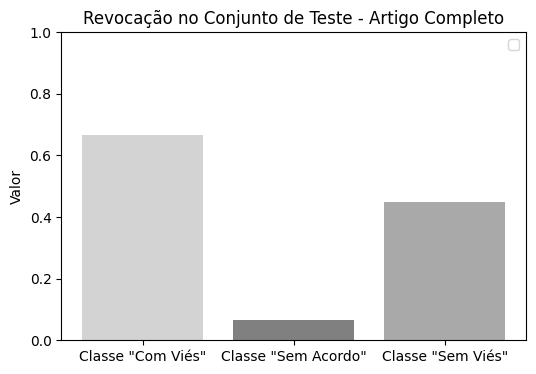

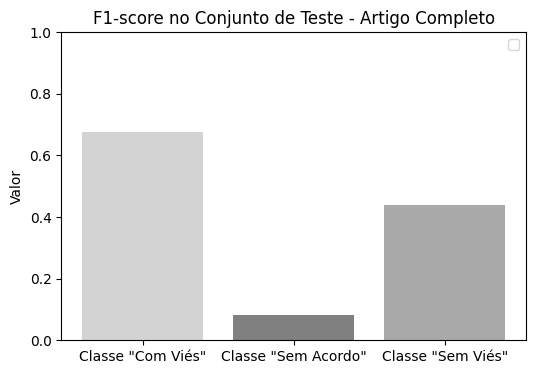

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular o F1-score para cada classe no conjunto de teste
test_f1_class0 = 2 * (test_precision_class0 * test_recall_class0) / (test_precision_class0 + test_recall_class0 + 1e-15)
test_f1_class1 = 2 * (test_precision_class1 * test_recall_class1) / (test_precision_class1 + test_recall_class1 + 1e-15)
test_f1_class2 = 2 * (test_precision_class2 * test_recall_class2) / (test_precision_class2 + test_recall_class2 + 1e-15)

# Preparar os dados para o gráfico de barras
metricas = ['Acurácia']
classes = ['Classe "Com Viés"', 'Classe "Sem Acordo"', 'Classe "Sem Viés"']
valores_acuracia = [test_accuracy]
valores_precisao = [test_precision_class0, test_precision_class1, test_precision_class2]
valores_revocacao = [test_recall_class0, test_recall_class1, test_recall_class2]
valores_f1 = [test_f1_class0, test_f1_class1, test_f1_class2]

# Criar o gráfico de barras para acurácia
plt.figure(figsize=(6, 4))
plt.bar(metricas, valores_acuracia, color='gray')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Acurácia no Conjunto de Teste')
plt.legend()

# Exibir o gráfico de barras de acurácia
plt.show()

# Criar o gráfico de barras para precisão
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_precisao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Precisão no Conjunto de Teste - Artigo Completo')
plt.legend()

# Exibir o gráfico de barras de precisão
plt.show()

# Criar o gráfico de barras para revocação
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_revocacao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Revocação no Conjunto de Teste - Artigo Completo')
plt.legend()

# Exibir o gráfico de barras de revocação
plt.show()

# Criar o gráfico de barras para F1-score
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_f1, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('F1-score no Conjunto de Teste - Artigo Completo')
plt.legend()

# Exibir o gráfico de barras de F1-score
plt.show()


# Usando a coluna sentence

In [ ]:
embed_size = 64

text_input_length = len(train_df.loc[1,'sentence'])
text_input = keras.layers.Input(shape=(text_input_length,))
embedding_layer = keras.layers.Embedding(input_dim=int(vocab_table.size())+5000,
                                         output_dim=embed_size,
                                         mask_zero=True)(text_input)

#embedding_output = keras.layers.Bidirectional(keras.layers.LSTM(embed_size))(embedding_layer)
embedding_output = keras.layers.LSTM(embed_size)(embedding_layer)
feature_input_length = len(train_df.columns) - 3
feature_input = keras.layers.Input(shape=(feature_input_length,))

concatenated = keras.layers.concatenate([embedding_output,feature_input], axis=-1)
reshaped = keras.layers.Reshape((-1, concatenated.shape[-1]))(concatenated)  # Add time dimension
gru_layer1 = keras.layers.LSTM(128)(reshaped)
dense = keras.layers.Dense(32, activation = 'relu')(gru_layer1)
dropout = keras.layers.Dropout(0.6)(dense) ### adicionando uma camada de regularização para diminuir diferença entre treino e validaçao
output = keras.layers.Dense(3, activation="softmax")(dropout)

model2 = tf.keras.Model(inputs=[text_input,feature_input], outputs=output)
#model.compile(loss="categorical_crossentropy",optimizer="adam")
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(class_id=0, name = 'prec_class0'),
                       Precision(class_id=1, name = 'prec_class1'),
                       Precision(class_id=2, name = 'prec_class2'),
                       Recall(class_id=0, name = 'rec_class0'),
                       Recall(class_id=1, name = 'rec_class1'),
                       Recall(class_id=2, name = 'rec_class2')])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="models/sentence_model.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

model2_train_metrics = model2.fit(split_metadata_and_text_features(train_df,'sentence'),
          train_labels,
          epochs=25,
          validation_data=(split_metadata_and_text_features(validation_df,'sentence'), validation_labels),
          batch_size=64,
          callbacks=[checkpoint_cb]
)

Epoch 1/25
17/17 [==============================] - 9s 217ms/step - loss: 1.0245 - accuracy: 0.5819 - prec_class0: 0.7183 - prec_class1: 0.0000e+00 - prec_class2: 0.0000e+00 - rec_class0: 0.0785 - rec_class1: 0.0000e+00 - rec_class2: 0.0000e+00 - val_loss: 0.8899 - val_accuracy: 0.6015 - val_prec_class0: 0.6765 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.0000e+00 - val_rec_class0: 0.8466 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0000e+00
Epoch 2/25
17/17 [==============================] - 1s 69ms/step - loss: 0.8905 - accuracy: 0.6059 - prec_class0: 0.6412 - prec_class1: 0.0000e+00 - prec_class2: 0.0000e+00 - rec_class0: 0.7862 - rec_class1: 0.0000e+00 - rec_class2: 0.0000e+00 - val_loss: 0.8477 - val_accuracy: 0.6052 - val_prec_class0: 0.6872 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.0000e+00 - val_rec_class0: 0.8896 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0000e+00
Epoch 3/25
17/17 [==============================] - 1s 63ms/step - loss: 0.8079 - accurac

11/11 [==============================] - 0s 12ms/step - loss: 4.0355 - accuracy: 0.5444 - prec_class0: 0.6854 - prec_class1: 0.0833 - prec_class2: 0.4122 - rec_class0: 0.6010 - rec_class1: 0.0333 - rec_class2: 0.5810


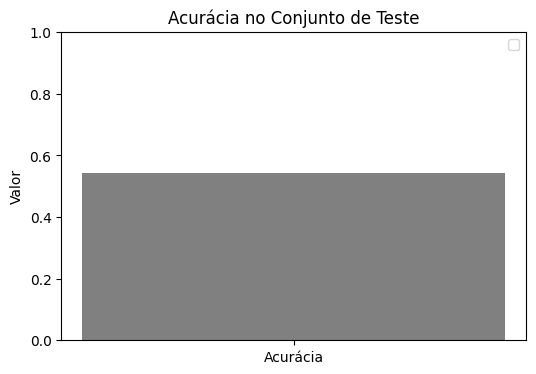

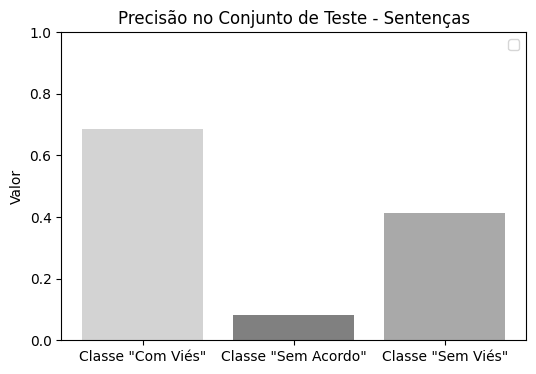

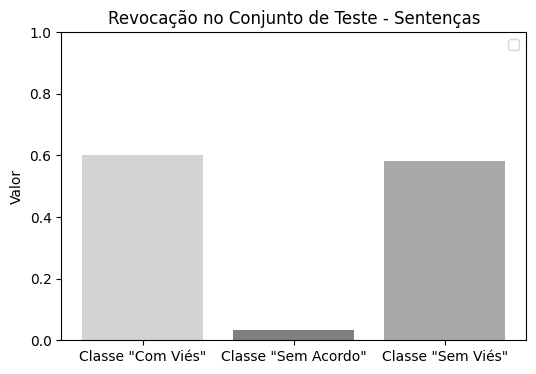

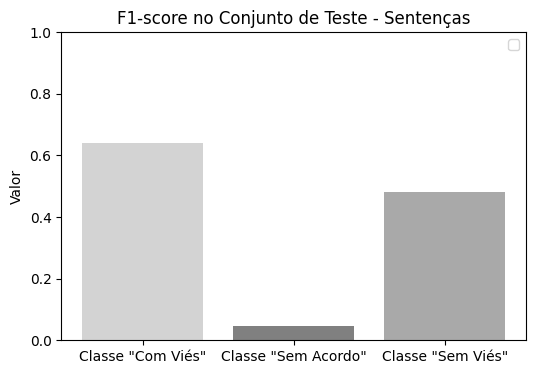

In [ ]:
# Calcular as métricas no conjunto de teste
test_loss, test_accuracy, test_precision_class0, test_precision_class1, test_precision_class2, test_recall_class0, test_recall_class1, test_recall_class2 = model2.evaluate(split_metadata_and_text_features(test_df, 'sentence'), test_labels)


# Calcular o F1-score para cada classe no conjunto de teste
test_f1_class0 = 2 * (test_precision_class0 * test_recall_class0) / (test_precision_class0 + test_recall_class0 + 1e-15)
test_f1_class1 = 2 * (test_precision_class1 * test_recall_class1) / (test_precision_class1 + test_recall_class1 + 1e-15)
test_f1_class2 = 2 * (test_precision_class2 * test_recall_class2) / (test_precision_class2 + test_recall_class2 + 1e-15)

# Preparar os dados para o gráfico de barras
metricas = ['Acurácia']
classes = ['Classe "Com Viés"', 'Classe "Sem Acordo"', 'Classe "Sem Viés"']
valores_acuracia = [test_accuracy]
valores_precisao = [test_precision_class0, test_precision_class1, test_precision_class2]
valores_revocacao = [test_recall_class0, test_recall_class1, test_recall_class2]
valores_f1 = [test_f1_class0, test_f1_class1, test_f1_class2]

# Criar o gráfico de barras para acurácia
plt.figure(figsize=(6, 4))
plt.bar(metricas, valores_acuracia, color='gray')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Acurácia no Conjunto de Teste')
plt.legend()

# Exibir o gráfico de barras de acurácia
plt.show()

# Criar o gráfico de barras para precisão
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_precisao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Precisão no Conjunto de Teste - Sentenças')
plt.legend()

# Exibir o gráfico de barras de precisão
plt.show()

# Criar o gráfico de barras para revocação
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_revocacao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Revocação no Conjunto de Teste - Sentenças')
plt.legend()

# Exibir o gráfico de barras de revocação
plt.show()

# Criar o gráfico de barras para F1-score
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_f1, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('F1-score no Conjunto de Teste - Sentenças')
plt.legend()

# Exibir o gráfico de barras de F1-score
plt.show()

## Usando apenas a palavra com vies

In [ ]:
embed_size = 64

text_input_length = len(train_df.loc[1,'biased_words4'])
text_input = keras.layers.Input(shape=(text_input_length,))
embedding_layer = keras.layers.Embedding(input_dim=int(vocab_table.size())+5000,
                                         output_dim=embed_size,
                                         mask_zero=True)(text_input)

#embedding_output = keras.layers.Bidirectional(keras.layers.LSTM(embed_size))(embedding_layer)
embedding_output = keras.layers.LSTM(embed_size)(embedding_layer)
feature_input_length = len(train_df.columns) - 3
feature_input = keras.layers.Input(shape=(feature_input_length,))

concatenated = keras.layers.concatenate([embedding_output,feature_input], axis=-1)
reshaped = keras.layers.Reshape((-1, concatenated.shape[-1]))(concatenated)  # Add time dimension
gru_layer1 = keras.layers.LSTM(128)(reshaped)
dense = keras.layers.Dense(32, activation = 'relu')(gru_layer1)
dropout = keras.layers.Dropout(0.6)(dense) ### adicionando uma camada de regularização para diminuir diferença entre treino e validaçao
output = keras.layers.Dense(3, activation="softmax")(dropout)

model3 = tf.keras.Model(inputs=[text_input,feature_input], outputs=output)
#model.compile(loss="categorical_crossentropy",optimizer="adam")
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(class_id=0, name = 'prec_class0'),
                       Precision(class_id=1, name = 'prec_class1'),
                       Precision(class_id=2, name = 'prec_class2'),
                       Recall(class_id=0, name = 'rec_class0'),
                       Recall(class_id=1, name = 'rec_class1'),
                       Recall(class_id=2, name = 'rec_class2')])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="models/biased_words4_model.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

model3_train_metrics = model3.fit(split_metadata_and_text_features(train_df,'biased_words4'),
          train_labels,
          epochs=25,
          validation_data=(split_metadata_and_text_features(validation_df,'biased_words4'), validation_labels),
          batch_size=64,
          callbacks=[checkpoint_cb]
)

Epoch 1/25
17/17 [==============================] - 8s 129ms/step - loss: 1.0223 - accuracy: 0.5883 - prec_class0: 0.7812 - prec_class1: 0.0000e+00 - prec_class2: 0.0000e+00 - rec_class0: 0.0385 - rec_class1: 0.0000e+00 - rec_class2: 0.0000e+00 - val_loss: 0.9422 - val_accuracy: 0.6052 - val_prec_class0: 0.8571 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.0000e+00 - val_rec_class0: 0.2209 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0000e+00
Epoch 2/25
17/17 [==============================] - 0s 29ms/step - loss: 0.8696 - accuracy: 0.6170 - prec_class0: 0.6809 - prec_class1: 0.0000e+00 - prec_class2: 0.0000e+00 - rec_class0: 0.7092 - rec_class1: 0.0000e+00 - rec_class2: 0.0000e+00 - val_loss: 0.7865 - val_accuracy: 0.6015 - val_prec_class0: 0.6626 - val_prec_class1: 0.0000e+00 - val_prec_class2: 0.0000e+00 - val_rec_class0: 0.9877 - val_rec_class1: 0.0000e+00 - val_rec_class2: 0.0000e+00
Epoch 3/25
17/17 [==============================] - 0s 29ms/step - loss: 0.7499 - accurac

11/11 [==============================] - 0s 5ms/step - loss: 1.8261 - accuracy: 0.7041 - prec_class0: 0.7658 - prec_class1: 0.2857 - prec_class2: 0.6452 - rec_class0: 0.8374 - rec_class1: 0.0667 - rec_class2: 0.5714    


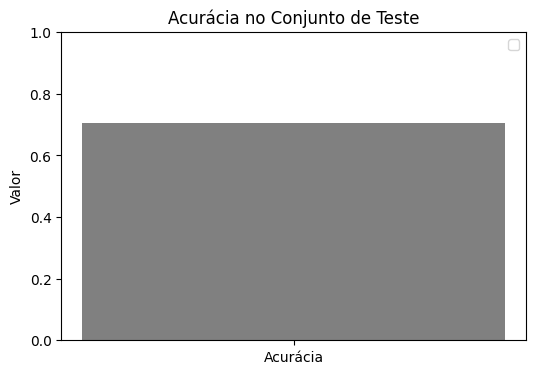

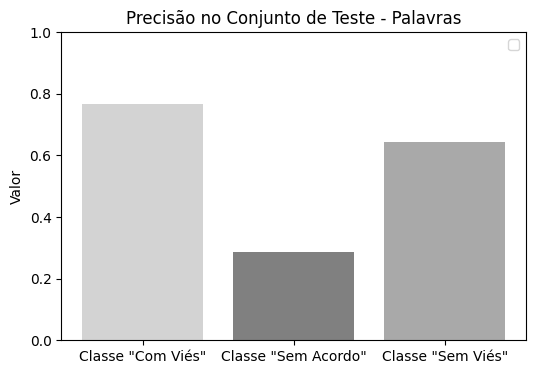

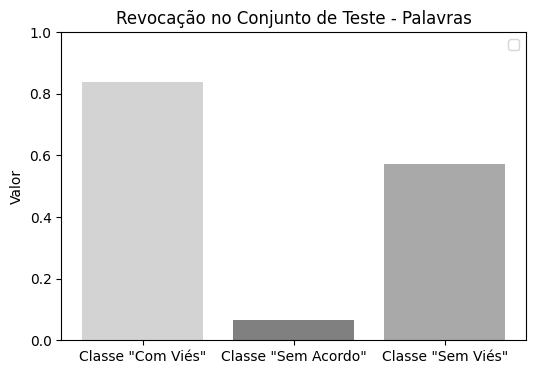

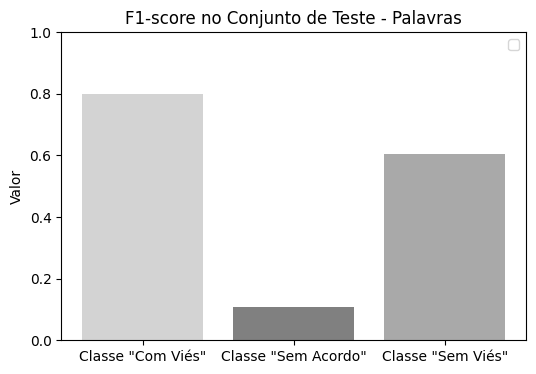

In [ ]:
# Calcular as métricas no conjunto de teste
test_loss, test_accuracy, test_precision_class0, test_precision_class1, test_precision_class2, test_recall_class0, test_recall_class1, test_recall_class2 = model3.evaluate(split_metadata_and_text_features(test_df, 'biased_words4'), test_labels)


# Calcular o F1-score para cada classe no conjunto de teste
test_f1_class0 = 2 * (test_precision_class0 * test_recall_class0) / (test_precision_class0 + test_recall_class0 + 1e-15)
test_f1_class1 = 2 * (test_precision_class1 * test_recall_class1) / (test_precision_class1 + test_recall_class1 + 1e-15)
test_f1_class2 = 2 * (test_precision_class2 * test_recall_class2) / (test_precision_class2 + test_recall_class2 + 1e-15)

# Preparar os dados para o gráfico de barras
metricas = ['Acurácia']
classes = ['Classe "Com Viés"', 'Classe "Sem Acordo"', 'Classe "Sem Viés"']
valores_acuracia = [test_accuracy]
valores_precisao = [test_precision_class0, test_precision_class1, test_precision_class2]
valores_revocacao = [test_recall_class0, test_recall_class1, test_recall_class2]
valores_f1 = [test_f1_class0, test_f1_class1, test_f1_class2]

# Criar o gráfico de barras para acurácia
plt.figure(figsize=(6, 4))
plt.bar(metricas, valores_acuracia, color='gray')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Acurácia no Conjunto de Teste')
plt.legend()

# Exibir o gráfico de barras de acurácia
plt.show()

# Criar o gráfico de barras para precisão
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_precisao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Precisão no Conjunto de Teste - Palavras')
plt.legend()

# Exibir o gráfico de barras de precisão
plt.show()

# Criar o gráfico de barras para revocação
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_revocacao, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Revocação no Conjunto de Teste - Palavras')
plt.legend()

# Exibir o gráfico de barras de revocação
plt.show()

# Criar o gráfico de barras para F1-score
plt.figure(figsize=(6, 4))
plt.bar(classes, valores_f1, color=['lightgray', 'gray', 'darkgray'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('F1-score no Conjunto de Teste - Palavras')
plt.legend()

# Exibir o gráfico de barras de F1-score
plt.show()